## 基于K线形态锤子线的趋势跟踪策略

### 1.基本原理

K线
实体
上影线 
下硬线 

锤子线的定义
实体处于整个价格区间上端，实体颜色本身不影响
下影线长度至少达到实体高度的2倍
上影线很短

### 2. 策略原理


在下跌过程中，当某一日出现锤子线，意味着当天行情先继续下跌后出现大反弹，行情可能由此反转，
由此以观察期均线识别趋势下跌，以下跌趋势中出现锤子线作为开仓信号；
采用移动止损方式进行止损构建此策略

止损条件
当天最低价<max(均价-观察期内一定倍数的标准差，开仓价-开仓时标准差）
移动止损和固定止损相结合

### 3.策略实现

#### 收集并计算数据

In [1]:
import numpy as np
import pandas as pd 
import tushare as ts

In [2]:
code = '002398'     #股票代码
body_size = 0.03      #表示锤子实体上限大小，基本为当日开盘价，实体不能太大，波动范围为3%
head_size = 0.5       #表示锤子上影线上限，基准为下影线长度，上影线要短一点，不能超过下影线的一半
tail_size = 2         #表示下影线与实体大小比值，下影线要大于实体两倍
length = 10           #表示观察期时间长短
stoplose_trigger = 1  #表示当价格偏离均线满足几倍标准差时止损

In [5]:
data = ts.get_k_data(code, start='2012-01-01',end='2017-01-01')
data.sort_index(ascending=True, inplace=True)
data.head()

,date,open,close,high,low,volume,code
0,2012-01-04,3.521,3.396,3.605,3.392,2834.0,002398
1,2012-01-05,3.383,3.057,3.396,3.057,8209.0,002398
2,2012-01-06,3.027,3.022,3.094,2.882,9726.0,002398
3,2012-01-09,3.020,3.152,3.165,2.953,5365.0,002398
4,2012-01-10,3.152,3.292,3.325,3.152,11215.0,002398


In [6]:
#计算离散return
data['pct_change'] = data['close'].pct_change()

In [7]:
#计算均值和方差
data['ma'] = data['close'].rolling(length).mean()
data['std'] =data['close'].rolling(length).std()

In [8]:
del data['volume']

In [9]:
data.head()

,date,open,close,high,low,code,pct_change,ma,std
0,2012-01-04,3.521,3.396,3.605,3.392,002398,NaN,NaN,NaN
1,2012-01-05,3.383,3.057,3.396,3.057,002398,-0.099823,NaN,NaN
2,2012-01-06,3.027,3.022,3.094,2.882,002398,-0.011449,NaN,NaN
3,2012-01-09,3.020,3.152,3.165,2.953,002398,0.043018,NaN,NaN
4,2012-01-10,3.152,3.292,3.325,3.152,002398,0.044416,NaN,NaN


由于实盘当天的日线级别参考指标第二天才能实现，因此使用昨日参考指标指导当日交易，避免未来数据

In [10]:
data['yes_ma'] = data['ma'].shift(1)
data['yes_std'] = data['std'].shift(1)

#### 识别锤子形态，计算上影线，下影线，实体

In [14]:
data['head'] = data['high'] - data[['close','open']].max(axis=1)  #计算头部,默认是按列计算的
data['body'] = abs(data['close']-data['open'])                   #计算body
data['tail'] = data[['close','open']].min(axis=1)-data['low']    #计算尾部
data.head()

,date,open,close,high,low,code,pct_change,ma,std,yes_ma,yes_std,head,body,tail
0,2012-01-04,3.521,3.396,3.605,3.392,002398,NaN,NaN,NaN,NaN,NaN,0.084,0.125,0.004
1,2012-01-05,3.383,3.057,3.396,3.057,002398,-0.099823,NaN,NaN,NaN,NaN,0.013,0.326,0.000
2,2012-01-06,3.027,3.022,3.094,2.882,002398,-0.011449,NaN,NaN,NaN,NaN,0.067,0.005,0.140
3,2012-01-09,3.020,3.152,3.165,2.953,002398,0.043018,NaN,NaN,NaN,NaN,0.013,0.132,0.067
4,2012-01-10,3.152,3.292,3.325,3.152,002398,0.044416,NaN,NaN,NaN,NaN,0.033,0.140,0.000


#### 判断K先各部分是否满足锤子线要求

In [19]:
data['head_cond'] = np.where(data['tail']==0, False, data['head']<0.5*data['tail'])     
#两步判断，先判断是否为0，如果为0，那么直接False，这些condition里面都是bool值
# 不为0才判断后面的
data['body_cond'] = np.where(data['body']/data['open']<0.03, 1,0)    
#实体小于开盘价的0.03
data['tail_cond'] = np.where(data['body']==0, True, data['tail']/data['body']>2)       
#当body为0的时候，是十字线，也认为是锤子线的一种
data['hammer'] = data[['head_cond','body_cond','tail_cond']].all(axis=1)   
#.all当所有条件满足时，才成立 .any当其中一个条件成立时就成立

In [21]:
data[data['hammer']].tail()    #把hammer的布尔值传递给data,data就会显示True的行

,date,open,close,high,low,code,pct_change,ma,std,yes_ma,yes_std,head,body,tail,head_cond,body_cond,tail_cond,hammer
1136,2016-10-13,6.574,6.569,6.574,6.506,002398,-0.000761,6.4186,0.110556,6.4143,0.104740,0.000,0.005,0.063,True,1,True,True
1144,2016-10-25,6.677,6.687,6.701,6.623,002398,0.000000,6.6183,0.053375,6.6007,0.057093,0.014,0.010,0.054,True,1,True,True
1145,2016-10-26,6.682,6.691,6.696,6.608,002398,0.000598,6.6300,0.055371,6.6183,0.053375,0.005,0.009,0.074,True,1,True,True
1167,2016-11-25,7.043,6.979,7.082,6.843,002398,-0.009087,7.0764,0.119415,7.0691,0.127957,0.039,0.064,0.136,True,1,True,True
1179,2016-12-13,6.306,6.340,6.374,6.223,002398,0.006989,6.6574,0.184610,6.7111,0.158244,0.034,0.034,0.083,True,1,True,True


In [22]:
data['yes_ham'] = data['hammer'].shift(1)

#### 计算交易逻辑

In [27]:
flag = 0     #记录持仓信号，0是空仓，1是持仓
for i in range(2*length, len(data)):     #从第20天开始，其实也可以从第10天开始，为了数据更可靠，从20天开始
    #如果已经持仓，判断是否止损
    if flag == 1:
        stoplose_price = max(data.loc[i, 'yes_ma'] - stoplose_trigger*data.loc[i, 'yes_std'],long_open_price-long_open_delta)
        #当天的价格低于止损价格，则进行止损，移动止损和固定止损相结合，移动均值减去一倍标准差，买入开盘价减去前一天的一倍标准差
        if data.loc[i, 'low'] < stoplose_price:
            flag = 0
            data.loc[i,'return'] = min(data.loc[i, 'open'], stoplose_price)/data.loc[i-1, 'close'] -1
            #计算清盘当天的收益，当开盘价就小于了止损价，那么就要以开盘价止损，不然会导致某些策略收益异常高估
            data.loc[i,'trade_mark'] = -10  #表示当天持仓并进行平仓，记录交易操作，测试代码
            #开仓时10，持仓为1
        #如果不满足止损条件，则继续持仓
        else:
            data.loc[i,'return'] = data.loc[i,'close']/data.loc[i-1,'close'] - 1   #收盘价计算收益
            data.loc[i,'trade_mark'] = 1
    else:
    #判断行情是否下跌，需要在下跌的情况下这个策略才有效,平均重心下降,这里不能用向前的判断，会引入未来数据，
    #只能用向后判断，这也是之前为什么从20天数据开始
        if data.loc[i-length, 'yes_ma'] > data.loc[i, 'yes_ma']:
            #判断是否符合锤子线
            if data.loc[i,'yes_ham']:
                #更改持仓标记
                flag = 1
                #记录开仓时价格及标准差，是为了做固定止损
                long_open_price =  data.loc[i, 'open']
                long_open_delta = data.loc[i, 'yes_std']
                #计算当天的收益率
                data.loc[i,'return'] = data.loc[i, 'close']/data.loc[i, 'open'] -1  #开盘的时候买入，买入当天的收益是收盘价减去开盘价
                data.loc[i, 'trade_mark'] = 10    #记录交易操作，测试代码
                #当天开仓之后不进行平仓判断

In [40]:
data.tail(50)

,date,open,close,high,low,code,pct_change,ma,std,yes_ma,...,tail,head_cond,body_cond,tail_cond,hammer,yes_ham,return,trade_mark,strategy_return,stock_return
1143,2016-10-24,6.599,6.687,6.711,6.584,002398,0.012568,6.6007,0.057093,6.5787,...,0.015,False,1,False,False,False,0.012568,1.0,1.986656,1.969081
1144,2016-10-25,6.677,6.687,6.701,6.623,002398,0.000000,6.6183,0.053375,6.6007,...,0.054,True,1,True,True,False,0.000000,1.0,1.986656,1.969081
1145,2016-10-26,6.682,6.691,6.696,6.608,002398,0.000598,6.6300,0.055371,6.6183,...,0.074,True,1,True,True,True,0.000598,1.0,1.987844,1.970259
1146,2016-10-27,6.657,6.682,6.760,6.657,002398,-0.001345,6.6413,0.053020,6.6300,...,0.000,False,1,False,False,True,-0.001345,1.0,1.985170,1.967609
1147,2016-10-28,6.667,6.696,6.735,6.613,002398,0.002095,6.6530,0.050599,6.6413,...,0.054,False,1,False,False,False,0.002095,1.0,1.989330,1.971731
1148,2016-10-31,6.648,6.677,6.721,6.608,002398,-0.002838,6.6667,0.031574,6.6530,...,0.040,False,1,False,False,False,-0.002838,1.0,1.983685,1.966137
1149,2016-11-01,6.662,6.838,6.872,6.662,002398,0.024113,6.6867,0.061003,6.6667,...,0.000,False,1,False,False,False,0.024113,1.0,2.031517,2.013545
1150,2016-11-02,6.784,6.770,6.872,6.745,002398,-0.009944,6.7009,0.062333,6.6867,...,0.025,False,1,False,False,False,-0.009944,1.0,2.011314,1.993522
1151,2016-11-03,6.726,6.862,6.911,6.716,002398,0.013589,6.7194,0.079532,6.7009,...,0.010,False,1,False,False,False,0.013589,1.0,2.038647,2.020612
1152,2016-11-04,6.833,6.828,6.887,6.735,002398,-0.004955,6.7418,0.074824,6.7194,...,0.093,False,1,True,False,False,-0.004955,1.0,2.028546,2.010601


#### 计算策略收益率

In [30]:
data['return'].fillna(0, inplace=True)
# 如果没有任何操作，就让这些天的收益都为0 
data['strategy_return'] = (data['return']+1).cumprod()
data['stock_return'] = (data['pct_change']+1).cumprod()

#### 绘图

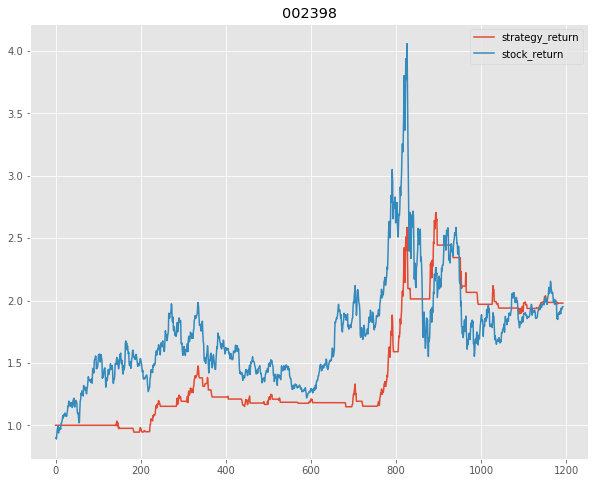

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)   #在fig里面添加子图
ax.plot(data.strategy_return)  #在子图里面画什么类容
ax.plot(data.stock_return)
plt.title(code)
plt.legend()
plt.show()

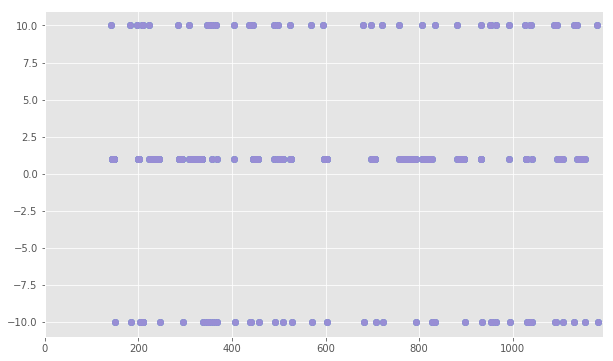

In [39]:
data['trade_mark'].plot(marker='o',figsize=(10,6),linestyle='')
plt.show()

In [41]:
data.to_csv('hammer.csv')